## EDA and Data Cleaning


In [80]:
import nltk
import pandas as pd
import string

In [81]:
# Data taken from: https://www.kaggle.com/datasets/chaitanyakck/medical-text
df = pd.read_csv("data/train.dat", sep="\t", header=None, names=["label", "text"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14438 entries, 0 to 14437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   14438 non-null  int64 
 1   text    14438 non-null  object
dtypes: int64(1), object(1)
memory usage: 225.7+ KB


In [82]:
df.head(10)

,label,text
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...
5,1,Infection during chronic epidural catheterizat...
6,5,Mediastinal tracheostomy using a pectoralis ma...
7,5,Tumefactive fibroinflammatory lesion of the ex...
8,3,Multiple representations contribute to body kn...
9,5,Increasing asthma prevalence in a rural New Ze...


In [83]:
# Check missing values
df.isna().sum()

label    0
text     0
dtype: int64

In [84]:
# Remove digits and punctuation
df["text"] = df["text"].map(lambda s: s.strip().lower())
df["text"] = df["text"].map(lambda s: s.translate(str.maketrans("", "", string.digits)))
df["text"] = df["text"].map(
    lambda s: s.translate(str.maketrans("", "", string.punctuation))
)

# Text has some duplicates, drop those
df = df.drop_duplicates(subset=["text"])

In [85]:
# from nltk.corpus import wordnet as wn

# nltk.download("wordnet")
# synonyms = wn.synsets("word")
# for syn in synonyms:
#     for lemma in syn.lemmas():
#         print(lemma.name())

# TODO: add synonyms, translations, or smth to create mote data
df.value_counts("label")

label
5    3509
1    2673
4    2477
3    1469
2    1098
Name: count, dtype: int64

In [86]:
print(f"No. of rows: {df.shape[0]}")
df.head(10)

No. of rows: 11226


,label,text
0,4,catheterization laboratory events and hospital...
1,5,renal abscess in children three cases of renal...
2,2,hyperplastic polyps seen at sigmoidoscopy are ...
3,5,subclavian artery to innominate vein fistula a...
4,4,effect of local inhibition of gammaaminobutyri...
5,1,infection during chronic epidural catheterizat...
6,5,mediastinal tracheostomy using a pectoralis ma...
7,5,tumefactive fibroinflammatory lesion of the ex...
8,3,multiple representations contribute to body kn...
9,5,increasing asthma prevalence in a rural new ze...


In [87]:
# Save cleaned data
df.to_csv("data/clean.dat", index=False, sep="\t")

## Models


In [133]:
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
from seaborn import heatmap
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [134]:
df = pd.read_csv("data/clean.dat", sep="\t")

nltk.download("stopwords")
stop_words = stopwords.words("english")


def show_eval(model, X_train, X_test, y_train, y_test):
    print("Train accuracy:", model.score(X_train, y_train))
    print("Test accuracy:", model.score(X_test, y_test))

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.show()


def transform_oversample(encoder, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    smote = SMOTETomek(n_jobs=-1)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiyonn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Logistic Regression


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


# Bag of words
cv = CountVectorizer(strip_accents="unicode", stop_words=stop_words)
X_train, X_test, y_train, y_test = transform_oversample(cv, df["text"], df["label"])

c:\Python312\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train accuracy: 0.9992060627932154
Test accuracy: 0.6357969723953696
              precision    recall  f1-score   support

           1       0.72      0.75      0.74       531
           2       0.64      0.61      0.63       223
           3       0.53      0.52      0.53       300
           4       0.69      0.75      0.72       454
           5       0.57      0.54      0.55       738

    accuracy                           0.64      2246
   macro avg       0.63      0.63      0.63      2246
weighted avg       0.63      0.64      0.63      2246



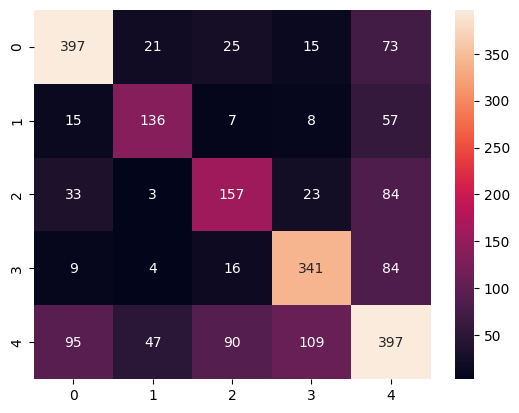

In [91]:
lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={"C": np.logspace(-3, 3, 7)},
    n_jobs=-1,
)


lr.fit(X_train, y_train)


show_eval(lr, X_train, X_test, y_train, y_test)

### Naive Bayes


In [135]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of n-grams
cv = CountVectorizer(
    strip_accents="unicode",
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=20000,
)
X_train, X_test, y_train, y_test = transform_oversample(cv, df["text"], df["label"])

c:\Python312\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [137]:
y_train.value_counts()

label
2    2817
3    2816
1    2815
4    2809
5    2809
Name: count, dtype: int64

Train accuracy: 0.8580264467510309
Test accuracy: 0.672306322350846
              precision    recall  f1-score   support

           1       0.78      0.81      0.79       585
           2       0.62      0.65      0.63       213
           3       0.53      0.62      0.57       284
           4       0.75      0.80      0.77       473
           5       0.60      0.50      0.54       691

    accuracy                           0.67      2246
   macro avg       0.65      0.67      0.66      2246
weighted avg       0.67      0.67      0.67      2246



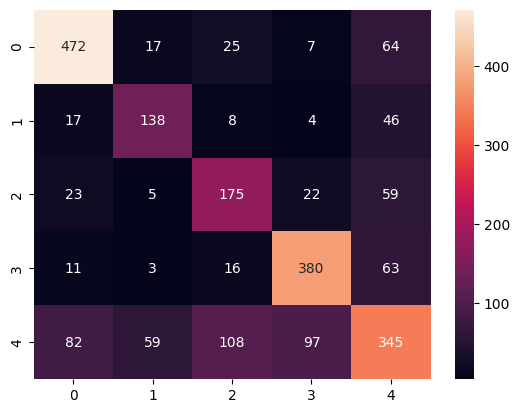

In [136]:
from sklearn.naive_bayes import MultinomialNB

MNB = GridSearchCV(
    MultinomialNB(),
    param_grid={"alpha": np.linspace(0.1, 1, 10)},
    n_jobs=-1,
)
MNB.fit(X_train, y_train)

show_eval(MNB, X_train, X_test, y_train, y_test)

### Support Vector Classification


In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfv = TfidfVectorizer(
    strip_accents="unicode",
    stop_words=stop_words,
    ngram_range=(1, 3),
    sublinear_tf=True,
    max_features=10000,
)
X_train, X_test, y_train, y_test = transform_oversample(tfv, df["text"], df["label"])

c:\Python312\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


c:\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train accuracy: 0.9829650748396294
Test accuracy: 0.6705253784505788
              precision    recall  f1-score   support

           1       0.76      0.79      0.78       544
           2       0.63      0.67      0.65       221
           3       0.58      0.54      0.56       280
           4       0.73      0.77      0.75       498
           5       0.60      0.56      0.58       703

    accuracy                           0.67      2246
   macro avg       0.66      0.67      0.66      2246
weighted avg       0.67      0.67      0.67      2246



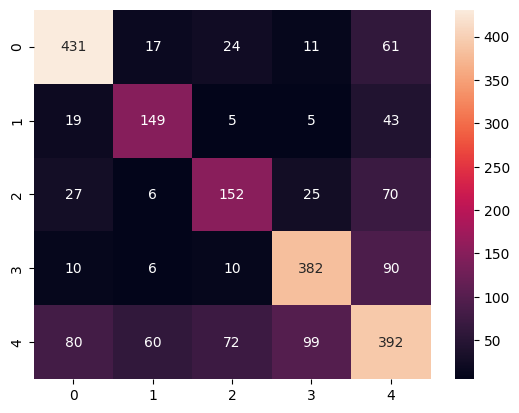

In [95]:
from sklearn.svm import LinearSVC

linearSVC = GridSearchCV(
    LinearSVC(),
    param_grid={"C": np.logspace(-3, 3, 7)},
    n_jobs=-1,
)
linearSVC.fit(X_train, y_train)

show_eval(linearSVC, X_train, X_test, y_train, y_test)

### RNN


In [96]:
# Prediction

# TODO: verify order
class_names = [
    "digestive system diseases",
    "cardiovascular diseases",
    "neoplasms",
    "nervous system diseases",
    "and general pathological conditions",
]